# Multiple linear regression model
**Here is how the equation looks**
>ΔR=β0​+β1​(Commercial Airbnb Listings)+β2​(Population Density)+β3​(Distance to Centre)+β4​(Deprivation)+ϵ
>
>Explanation:
>β0\beta_0β0​: Intercept (baseline rental price change when all predictors are zero).
β1,β2,β3,β4\beta_1, \beta_2, \beta_3, \beta_4β1​,β2​,β3​,β4​: Coefficients representing the effect of each predictor on rental price changes.
ϵ\epsilonϵ: Error term that captures variability in ΔR\Delta RΔR not explained by the predictors.



In [21]:
# load packages
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import requests
import zipfile
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import fcluster, linkage
from dateutil.relativedelta import relativedelta
from datetime import datetime
from PIL import Image
from io import BytesIO
from shapely.geometry import Point
from urllib.parse import urlparse

pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 200

In [97]:
import pandas as pd

# Reading the data
df_rentalprice = pd.read_csv("https://github.com/a-saveleva/FSDS_Slap/blob/main/private_Rent/onsrents.csv?raw=true")

# Filtering for London boroughs based on Area Code
df_london = df_rentalprice[df_rentalprice['Area code'].str.startswith('E09')]

# Resetting the index of the filtered DataFrame
df_london = df_london.reset_index(drop=True)

# Ensure 'Time period' is in datetime format
df_london['Time period'] = pd.to_datetime(df_london['Time period'], errors='coerce')

# Define the start and end dates of the financial year 2022-223
start_date_2022 = pd.to_datetime("2022-04-01")
end_date_2022 = pd.to_datetime("2023-03-31")

# Filter for the 2022-23 financial year
filtered_rents_2022 = df_london[(df_london['Time period'] >= start_date_2022) & (df_london['Time period'] <= end_date_2022)]

# Grouping by Area code and Area name to calculate the average rental price for 2022-23
monthly_avg_rent_2022 = filtered_rents_2022.groupby(['Area code', 'Area name'])['Rental price'].mean().reset_index()

# Renaming the columns for clarity for 2022-23
monthly_avg_rent_2022.columns = ['Mnemonic', 'Borough Name', 'Average Rental Price 2022-23']

# Define the start and end dates of the financial year 2020-21
start_date_2023 = pd.to_datetime("2023-04-01")
end_date_2023 = pd.to_datetime("2024-03-31")

# Filter for the 2023-24 financial year
filtered_rents_2023 = df_london[(df_london['Time period'] >= start_date_2023) & (df_london['Time period'] <= end_date_2023)]

# Grouping by Area code and Area name to calculate the average rental price for 2020-21
monthly_avg_rent_2023 = filtered_rents_2023.groupby(['Area code', 'Area name'])['Rental price'].mean().reset_index()

# Renaming the columns for clarity for 2020-21
monthly_avg_rent_2023.columns = ['Mnemonic', 'Borough Name', 'Average Rental Price 2023-24']

# Merging the two datasets (2022-23 and 202-22) by 'Mnemonic' and 'Borough Name'
df_rental_comparison = pd.merge(monthly_avg_rent_2022, monthly_avg_rent_2023, on=['Mnemonic', 'Borough Name'], how='inner')


# Check for missing values in the merged DataFrame
print(df_rental_comparison.isnull().sum())

# Calculate the difference between the two financial years
df_rental_comparison['Price_Difference'] = df_rental_comparison['Average Rental Price 2023-24'] - df_rental_comparison['Average Rental Price 2022-23']

# Displaying the updated DataFrame
print(df_rental_comparison)



Mnemonic                        0
Borough Name                    0
Average Rental Price 2022-23    0
Average Rental Price 2023-24    0
dtype: int64
     Mnemonic            Borough Name  Average Rental Price 2022-23  \
0   E09000002    Barking and Dagenham                   1286.500000   
1   E09000003                  Barnet                   1534.916667   
2   E09000004                  Bexley                   1191.666667   
3   E09000005                   Brent                   1499.000000   
4   E09000006                 Bromley                   1373.833333   
5   E09000007                  Camden                   2169.333333   
6   E09000008                 Croydon                   1242.500000   
7   E09000009                  Ealing                   1590.416667   
8   E09000010                 Enfield                   1386.750000   
9   E09000011               Greenwich                   1500.583333   
10  E09000012                 Hackney                   1977.750000   

**Reading in the population density data**

In [23]:
df_censuspopdens = pd.read_csv("https://github.com/a-saveleva/FSDS_Slap/blob/main/census_data/Census_PopDensity.csv?raw=true", 
                                  skiprows = 6, nrows = 33 ,usecols = ['mnemonic', '2021'])

df_censuspopdens.rename(columns={'2021':'PopDensity'}, inplace=True)

# Mapping of mnemonic codes to borough names
mnemonic_to_borough = {
    'E09000001': 'City of London',
    'E09000002': 'Barking and Dagenham',
    'E09000003': 'Barnet',
    'E09000004': 'Bexley',
    'E09000005': 'Brent',
    'E09000006': 'Bromley',
    'E09000007': 'Camden',
    'E09000008': 'Croydon',
    'E09000009': 'Ealing',
    'E09000010': 'Enfield',
    'E09000011': 'Greenwich',
    'E09000012': 'Hackney',
    'E09000013': 'Hammersmith and Fulham',
    'E09000014': 'Haringey',
    'E09000015': 'Harrow',
    'E09000016': 'Havering',
    'E09000017': 'Hillingdon',
    'E09000018': 'Hounslow',
    'E09000019': 'Islington',
    'E09000020': 'Kensington and Chelsea',
    'E09000021': 'Kingston upon Thames',
    'E09000022': 'Lambeth',
    'E09000023': 'Lewisham',
    'E09000024': 'Merton',
    'E09000025': 'Newham',
    'E09000026': 'Redbridge',
    'E09000027': 'Richmond upon Thames',
    'E09000028': 'Southwark',
    'E09000029': 'Sutton',
    'E09000030': 'Tower Hamlets',
    'E09000031': 'Waltham Forest',
    'E09000032': 'Wandsworth',
    'E09000033': 'Westminster'
}

# Add a column for borough names
df_censuspopdens['Borough'] = df_censuspopdens['mnemonic'].map(mnemonic_to_borough)

# Display the updated DataFrame
#print(df_censuspopdens)


**Reading in the vacant homes data**

In [24]:
#https://data.london.gov.uk/download/vacant-dwellings/c428a18b-9961-4b98-9cfe-b7f120114141/vacant-dwellings-borough%20%282%29.xlsx
df_vacantprops = pd.read_excel("https://data.london.gov.uk/download/vacant-dwellings/c428a18b-9961-4b98-9cfe-b7f120114141/vacant-dwellings-borough%20%282%29.xlsx", 
                                  sheet_name = 2, skiprows = 1, nrows = 34)

#df_vacantprops.dropna(inplace = True)
#df_vacantprops.shape

df_vacantprops.rename(columns={'Unnamed: 0':'LAcode'}, inplace=True)
df_vacantprops.rename(columns={'Unnamed: 1':'LAname'}, inplace=True)

#df_vacantprops.dtypes

df_vacantprops.dropna(inplace=True)

print(df_vacantprops)


       LAcode                  LAname    2004    2005    2006    2007    2008  \
1   E09000001          City of London   119.0    86.0    55.0    54.0    47.0   
2   E09000002    Barking and Dagenham   434.0   513.0   893.0  1181.0   750.0   
3   E09000003                  Barnet  1654.0  1805.0  1604.0  1576.0  1704.0   
4   E09000004                  Bexley   898.0   932.0   823.0   911.0   756.0   
5   E09000005                   Brent  1294.0  1231.0  1214.0  1162.0   830.0   
6   E09000006                 Bromley  1506.0  1437.0  1253.0  1138.0  1047.0   
7   E09000007                  Camden  1503.0  1338.0  1056.0  1079.0  1125.0   
8   E09000008                 Croydon  2978.0  2049.0  2721.0  1822.0  1640.0   
9   E09000009                  Ealing  1215.0  1179.0  1091.0  1131.0  1144.0   
10  E09000010                 Enfield  2848.0  2661.0  3028.0  1551.0   905.0   
11  E09000011               Greenwich  1314.0  1362.0  1510.0  1406.0  1466.0   
12  E09000012               

**Reading in the tenure data**

In [25]:
df_censusTenure = pd.read_csv("https://github.com/a-saveleva/FSDS_Slap/blob/main/census_data/Census_Tenure.csv?raw=true", 
                                  skiprows = 6, nrows = 33, usecols = ['mnemonic', 'Owned', 'Shared ownership',
                                                                      'Social rented', 
                                                                       'Private rented or lives rent free'])

#calculating the proportions of owned and rented 
df_censusTenure['Rented'] = df_censusTenure[['Shared ownership', 'Social rented', 'Private rented or lives rent free']].sum(axis=1)

#creating a composite variable 
df_censusTenure['Owned_to_Rented_Ratio'] = df_censusTenure['Owned'] / df_censusTenure['Rented']
#to assess how changes in the proportion of owned versus rented properties influence rental price changes.

print(df_censusTenure)

     mnemonic  Owned  Shared ownership  Social rented  \
0   E09000002   42.4               1.7           31.5   
1   E09000003   52.7               1.1           13.5   
2   E09000004   68.6               1.3           14.7   
3   E09000005   38.4               1.9           23.5   
4   E09000006   68.5               0.9           13.2   
5   E09000007   29.7               0.8           33.7   
6   E09000001   36.5               0.2           14.9   
7   E09000008   54.7               1.4           17.9   
8   E09000009   46.2               2.0           17.5   
9   E09000010   52.4               1.1           17.0   
10  E09000011   41.1               2.2           31.0   
11  E09000012   24.6               2.5           40.5   
12  E09000013   32.1               1.5           29.8   
13  E09000014   37.2               1.6           25.2   
14  E09000015   58.8               1.1           10.4   
15  E09000016   69.5               1.0           13.6   
16  E09000017   56.6           

**reading airbnb data and calculating how many listings were vacant for 36 days**

In [27]:
#| echo: false
def cache_data(src:str) -> str:
    """Downloads and caches a remote file locally.
    src : str - The remote *source* for the file, any valid URL should work.
    dest : str - The *destination* location to save the downloaded file.    
    Returns a string representing the local location of the file.
    """
    dest = os.path.join('data','raw') #destination to save data
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn = (url.path.split('/')[-3])+(url.path.split('/')[-1]) # return the file name with date
    dfn = os.path.join(dest,fn) # Destination filename
    print(f"Writing to: {fn}")

    if not os.path.isfile(dfn) or os.stat(dfn).st_size < 250:
        
        print(f"{dfn} not found or corrupted, downloading!")
        path = os.path.split(dest)
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            # Download and save the file #os.path.join(*path)
            try:
                with open(dfn, "wb") as file:
                    response = requests.get(src)
                    response.raise_for_status()  # Raise an exception for HTTP errors
                    file.write(response.content)
                print("\tDone downloading.")
            except Exception as e:
                print(f"Error: {e}")
                
        f_size = os.stat(dfn).st_size
        print(f"\tSize is {f_size/1024**2:,.0f} MB ({f_size:,} bytes)")
    else:
        print(f"Found {dfn} locally!")
        f_size = os.stat(dfn).st_size
        print(f"\tSize is {f_size/1024**2:,.0f} MB ({f_size:,} bytes)")
        
    return dfn 

In [28]:
#| echo: false
#_____________________________________________________________________________________________________________________________
# Set download URL for London data the date should be choosen by reviewing 
# the InsideAirbnb Get Data page and identifying the date of the required data
# We are using the 2 datasets with earliest and latest scrape of those available
#_____________________________________________________________________________________________________________________________
airbnbdates  = ["2023-12-10", "2024-09-06"]
airbnbcols = ['id', 'listing_url', 'picture_url', 'host_id', 'host_listings_count',
              'host_total_listings_count', 'property_type', 'room_type', 'price', 
              'minimum_nights', 'maximum_nights', 'availability_365', 
              'number_of_reviews', 'latitude', 'longitude', 'last_review', 
              'beds', 'bedrooms']
airbnbdfs = []
for date in airbnbdates:
    airbnburl  = f"https://data.insideairbnb.com/united-kingdom/england/london/{date}/data/listings.csv.gz"
    dfn = cache_data(airbnburl)
    airbnbdfs.append(pd.read_csv(dfn, low_memory=False,usecols=airbnbcols))
   
airbnb_dflist = [airbnb_old, airbnb_new] = airbnbdfs #airbnb_old is the earlier scrape, and new is the later scrape. We don't hardcode the dates for reproducibility with other dates and times.

airbnb_gdfs = []
for df in airbnb_dflist:
#_____________________________________________________________________________________________________________________________
#   I convert the df into gdf, reproject into EPSG 27700
#_____________________________________________________________________________________________________________________________  
    df = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs='EPSG:4326')
    
    df = df.set_crs('EPSG:4326', allow_override=True)
    df.to_crs('EPSG:27700', inplace=True)
    airbnb_gdfs.append(df)

Writing to: 2023-12-10listings.csv.gz
Found data/raw/2023-12-10listings.csv.gz locally!
	Size is 31 MB (32,102,141 bytes)
Writing to: 2024-09-06listings.csv.gz
Found data/raw/2024-09-06listings.csv.gz locally!
	Size is 48 MB (50,734,149 bytes)


In [29]:
#| echo: false
#_____________________________________________________________________________________________________________________________
# InsideAirbnb data cleaning. We first define the functions to be used in cleaning.
#_____________________________________________________________________________________________________________________________
def pick_active_listings(df, date='str', col="str"):
    """
    Converting review column to datetime, and selecting only the recently active listings. 
    Recently active is defined as those which received at least one review for the year precedeng the scrape.
    Arguments:
    date: string, format "%Y-%m-%d"
    dataframe
    col: string, colname with "last_review" or its alternative
    """
    df.loc[:, col] = pd.to_datetime(df[col])
    date = datetime.strptime(date, "%Y-%m-%d")
    df = df[df['last_review'] > (date - relativedelta(years=1))] #| (df['last_review'].isnull())]
    
    print(f"Data frame after filtering last review date is {df.shape[0]:,} x {df.shape[1]} long.")
    return df

In [30]:
#| echo: false
#_____________________________________________________________________________________________________________________________
# Why do we remove duplicates?
# In the regression part of our analysis, we  want to calculate N of homes that are somehow involved in Airbnb listings, and therefore don't fulle realise it's potential on traditional rental/housing market.
# If we took just listing locations, with the amount of duplicates that we found, the N would show ACTIVITY of hosts more than loss of homes for housing market.
# ChatGPT was used here to determine clustering methods, and for debugging.
#_____________________________________________________________________________________________________________________________

def find_duplicates(df_valid):
    """
    The function looks at hosts with multiple listings and checks if they are within 300m radius (150m max location scattering as per Airbnb's anonymisation algorithm, x2).
    It then estimates the number of genuine homes within the cluster.
    
    Returns a gdf with new columns: 
    'cluster_id' - each unique value is a cluster
    'easting', 'northing' - used in calculating the proximity of listings
    'prvt_rms_in_cluster','entr_hms_in_cluster' - summarises N of private rooms and entire homes within the cluster
    'genuine', 'true_nrooms' - boolean column, and int column, with the following assumptions:

    If the cluster has 0 entire homes, and N rooms, first room will be "converted" to an entire home, and the rest will be discarded. 
    The location of the point will be amended to represent centrepoint of all rooms in the cluster.
    Record of the N of rooms will stay in col "true_nrooms"
    If the cluster has rooms and entire homes, the homes will be treated as genuine homes, and rooms treated as duplicates of the genuine home. 
    With the current timeframes, further enquiries into uniqueness of homes vs rooms inside each cluster is not feasible.
    """
    
    df['easting'], df['northing'] = df.geometry.x, df.geometry.y #this is needed for the clustering  
#_____________________________________________________________________________________________________________________________
#   We are looking for duplicates among multi-listing hosts. First, we filter by new_listings_count > 1.
#_____________________________________________________________________________________________________________________________
    finddups = df_valid[df_valid['new_host_listings_count'] > 1]
    print(f"There are {finddups.shape[0]:,} listings from multi-listing hosts.")
#_____________________________________________________________________________________________________________________________
#   I perform cluster analysis a1nd mark listings from the same host that are within 300m from each other 
#   (150m max location scattering as per Airbnb's anonymisation algorithm, x2). They constitute a cluster, and we then assess if they are a duplicate or not.
#   The selected method computes pairwise distances  can calculate the distance matrix between all points in a group. 
#   Before this method I tried KNN, but the listings were paired incorrectly. 
#   cdist solved this, and it is relatively light on small groups (our dataset is large, but it is split into small groups - by host).
#
#   It is possible, that listings outside clusters also could be in one entire home. E.g. there could be several hosts registered for one home.
#   We acknowledge this gap, and advise this for further research.
#_____________________________________________________________________________________________________________________________
    # Process each host group
    for host_id, group in finddups.groupby("host_id"):
        if len(group) > 1:  # Only proceed if there is more than 1 listing
            coords = group[['easting', 'northing']].to_numpy()
            
            # Calculate pairwise distances using pdist (returns condensed distance matrix)
            dist_matrix = pdist(coords)
            
            # Perform hierarchical clustering using the condensed distance matrix
            linkage_matrix = linkage(dist_matrix, method='single')
            clusters = fcluster(linkage_matrix, t=300, criterion='distance')
            
            # Create a series to count cluster sizes
            cluster_sizes = pd.Series(clusters).value_counts()
    
            # Assign clusters to rows in the group, but only for clusters with more than one member - these will retain default column value of None
            finddups.loc[group.index, 'cluster_id'] = [
                f"{host_id}-{cluster}" if cluster_sizes[cluster] > 1 else None
                for cluster in clusters
            ]
#_____________________________________________________________________________________________________________________________
#   We create a subset with non-unique listings only to calculate true_nrooms and determine genuineness.
#   At the very end of the function, this subset is merged back into df_valid.
#_____________________________________________________________________________________________________________________________
    finddups1 = finddups[~finddups['cluster_id'].isna()]
    finddups1 = finddups1.loc[finddups.duplicated(subset='cluster_id', keep=False)]   
    print(f"Found {len(set(finddups1.cluster_id)):,} clusters.")   
#_____________________________________________________________________________________________________________________________
#   I calculate N of entire homes and rooms in each cluster.
#   Limitation found during EDA: "bedrooms" column in InsideAirbnb differs between scrapes. 
#   "2023-12-10" scrape has NaN values in this column, while "2024-09-06" scrape has full data.
#   For both datasets, we use "beds" column as a substitute, because airbnb2024.bedrooms.median()/airbnb2024.beds.median() = 1.
#_____________________________________________________________________________________________________________________________
    finddups1 = finddups.loc[finddups.duplicated(subset='cluster_id',keep=False)]
#   Loop through each cluster by cluster_id. 
    for i, group in finddups1.groupby("cluster_id"):
        # Count number of entire homes and private rooms in the group
        n_entire_homes = group[group['room_type'] == 'Entire home/apt'].shape[0]
        n_private_rooms = group[group['room_type'] == 'Private room'].shape[0]   
        # Assign these counts back to the original DataFrame
        finddups1.loc[group.index, 'entr_hms_in_cluster'] = n_entire_homes
        finddups1.loc[group.index, 'prvt_rms_in_cluster'] = n_private_rooms          
#_____________________________________________________________________________________________________________________________
#   I then determine whether listings are genuine unique homes, or rooms from one entire home.
#   If the cluster has 0 entire homes, and N rooms, first room will be "converted" to an entire home, and the rest will be discarded.
#   Record of the N of rooms will stay in col "true_nrooms".
#   If the cluster has rooms and entire homes, the homes will be treated as genuine homes, and rooms treated as duplicates of the genuine home.
#   It is possible that all entire homes in one cluster are absolutely identical, but with the methods employed we can go this far. We acknowledge the gap and suggest it for further research.
#_____________________________________________________________________________________________________________________________
    for cluster_id, group in finddups1.groupby("cluster_id"):
        
        num_entire_homes = (group['room_type'] == 'Entire home/apt').sum()
        if num_entire_homes == 0:
            # If only rooms are in the cluster
            finddups1.loc[group.index, 'genuine'] = False  # Mark all as duplicates
            finddups1.loc[group.index[0], 'genuine'] = True  # First room becomes the genuine home
#_____________________________________________________________________________________________________________________________
#           but the geometry is replaced with centroid x and y.  
#           Without this the point and all associated rooms can be aggregated by different spatial unit, considering the scale of the location approximation (up to 150m from origin).
#           This is not crucial for our research, because we aggregate by borough, and potential aggregation errors will be minimal. But for other research with smaller geospatial units it will prove more useful.
#_____________________________________________________________________________________________________________________________
            dissolved_geometry = group.geometry.union_all()  # Combine all geometries in the group
            centroid = dissolved_geometry.centroid # Get the centroid of the combined geometry
            finddups1.at[group.index[0], 'geometry'] = Point(centroid.x, centroid.y)
        else:
            # Cluster has both rooms and entire homes
            finddups1.loc[group.index, 'genuine'] = False  # Default all to duplicates
            entire_home_indices = group[group['room_type'] == 'Entire home/apt'].index
            finddups1.loc[entire_home_indices, 'genuine'] = True  # Mark entire homes with true

    print(f"The clustering exercise identified {len(finddups1[finddups1['genuine'] == False])} listings that are potentially duplicates of other listings.")
    df_valid.update(finddups1)
    
    return df_valid

In [31]:
#| echo: false
airbnb_gdf_clean = []
airbnb_gdf_ingenuine = []

for df in airbnb_gdfs:
    print(f"Initial dataframe is {df.shape[0]:,} x {df.shape[1]} long.")
    df['price'] = df['price'].fillna('0').str.replace('$', '', regex=False).str.replace(',', '').astype(float).astype(int)
    df.drop(df[df["price"]==0].index, axis=0, inplace=True)
    print(f"Data frame after filtering invalid prices is {df.shape[0]:,} x {df.shape[1]} long.")
    
    df = pick_active_listings(df, date, "last_review")

    ints  = ['id', 'host_listings_count', 'host_id', 'bedrooms', 'beds', 
             'host_total_listings_count', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews']
    for i in ints:
        #print(f"Converting {i}")
        try:
            df.loc[:, i] = df[i].fillna(0).astype(float).astype(int)
        except ValueError as e:
            #print("  - !!!Converting to unsigned 16-bit integer!!!")
            df.loc[:, i] = df[i].fillna(0).astype(float).astype(pd.UInt16Dtype())
    #_____________________________________________________________________________________________________________________________
    # After these transformations, the N of listings for each host has changed. We dropped rows where listings were likely inactive at the time of the scrape.
    # We create a new column with host_listings_count, and calculate the counts using grouping by host_id.
    #_____________________________________________________________________________________________________________________________
    host_counts = df['host_id'].value_counts()
    df = pd.merge(df,host_counts,right_index=True,left_on='host_id').rename(columns={'count':'new_host_listings_count'})
        
    # null values in N of bedrooms will interfere with our analysis, therefore we drop them
    df = df[df['beds'].notna()]
    print(f"Data frame after cleaning invalid N of beds is {df.shape[0]:,} listings long.")
    
    # creating columns necessary for the analysis and filling with default values
    df['prvt_rms_in_cluster'] = df['beds'] #be are using beds for rooms, but for now just copy the column
    df['entr_hms_in_cluster'] = 0 #default will be 0
    df['cluster_id'] = None #will write ids here
    #df['true_nrooms'] = df['beds'] #estimation of true n of rooms proved inconclusive with the methods used. The parts related to rooms are commented out.
    df['genuine'] = True   
    
    dups = find_duplicates(df) 
    airbnb_gdf_ingenuine.append((dups[dups['genuine'] == False]).copy()) #collecting False for validation
    
    df = (df[df['genuine'] == True]).copy()
    print(f"Data frame after cleaning duplicate listings is {df.shape[0]:,} listings long.\n")
    
    airbnb_gdf_clean.append(df)

Initial dataframe is 91,778 x 19 long.
Data frame after filtering invalid prices is 87,598 x 19 long.
Data frame after filtering last review date is 32,549 x 19 long.
Data frame after cleaning invalid N of beds is 32,549 listings long.
There are 18,246 listings from multi-listing hosts.
Found 4,329 clusters.
The clustering exercise identified 4297 listings that are potentially duplicates of other listings.
Data frame after cleaning duplicate listings is 28,252 listings long.

Initial dataframe is 96,182 x 19 long.
Data frame after filtering invalid prices is 63,205 x 19 long.
Data frame after filtering last review date is 42,667 x 19 long.
Data frame after cleaning invalid N of beds is 42,667 listings long.
There are 25,512 listings from multi-listing hosts.
Found 5,871 clusters.
The clustering exercise identified 5643 listings that are potentially duplicates of other listings.
Data frame after cleaning duplicate listings is 37,024 listings long.



In [13]:
#| echo: false
#_____________________________________________________________________________________________________________________________
#   You might wonder, whether the find_duplicates function works properly.
#   We acknowledge that, given the timeframes, and considering that our research question is not specifically about duplicates,
#   it is not feasible to develop a complex validation mechanism.
#   However, you can see for yourself the results of the clustering and our assumptions, using the function below.
#_____________________________________________________________________________________________________________________________

# This was not developed as a aproper validation tool, only as a proof of concept of finding duplicates.
# As this is not the main part of the exercise, ChatGPT was heavily used here to set up thumbnail plotting.

def check_genuine(df, **kwargs):
    """
    Receives df and random_state as args. If unspecified, gives random number as random_state.
    Displays the random ingenuine listing, and other listings from its cluster as clickable image thumbnails.
    """
    if not kwargs.get('random_state'):
        random_state = random.randint(0,1000)
    else:
        random_state = kwargs.get('random_state')
    print(f'Random_state unspecified, selecting:{random_state}.')
    
    # Select a random "ingenuine" listing from the dataset
    listing_check = df[df['genuine'] == False].sample(1, random_state=random_state)
    
    print(f"Let's have a look at the random listing. ID: {listing_check.id.values[0]}")
    print(f"Cluster number {listing_check.cluster_id.values[0]}")
    
    if (listing_check['beds'] > 4).any():
        print("Our estimate is that this might be a hostel, party home or similar hishly commercialised listing.")
    else:
        print("Our estimate is that this cluster might be one entire home, and is a significant loss to housing and rental market.")
    
    print("All listings in this cluster are below. Click on the image to open the listings on website.")
    print("You might get inactive links with past datasets.")
    
    # Get all listings in the same cluster
    same_cluster = df[df["cluster_id"] == listing_check.cluster_id.values[0]]
    # print(same_cluster[["id", "listing_url"]])
    
    # Collect successful images and their associated URLs
    successful_images = []
    urls = []
    
    for idx, row in same_cluster.iterrows():
        try:
            response = requests.get(row['picture_url'], timeout=10)
            response.raise_for_status()  # Raise an error for HTTP issues
            img = Image.open(BytesIO(response.content))
            img.thumbnail((190, 190))  # Resize image for thumbnail display
            successful_images.append((img, row['listing_url']))
        except Exception as e:
            print(f"Failed to retrieve image for Listing ID: {row['id']}. Error: {e}")
    
    # If no successful images, return early
    if not successful_images:
        print("No images could be retrieved.")
        return
    
    # Render images and clickable links in Quarto Markdown
    html_content = "<table>"
    for i, (img, url) in enumerate(successful_images):
        if i % 3 == 0:  # Start a new row every 3 images
            html_content += "<tr>"
        
        # Convert the image to a data URL
        img_buffer = BytesIO()
        img.save(img_buffer, format="PNG")
        img_data = img_buffer.getvalue()
        img_base64 = base64.b64encode(img_data).decode('utf-8')  # Encoding the image
        img_src = f"data:image/png;base64,{img_base64}"
        
        # Add the image and link to the HTML
        html_content += f"""
        <td style="text-align:center; padding:5px">
            <a href="{url}" target="_blank"><img src="{img_src}" style="width:128px; height:auto; border:1px solid #ccc" /></a>
        </td>
        """
        if i % 3 == 2:  # End the row every 3 images
            html_content += "</tr>"
    
    html_content += "</table>"
    
    # Display the HTML in Quarto
    display.display(display.HTML(html_content))

In [32]:
print(type(airbnb_gdf_clean))

<class 'list'>


In [36]:
# Print the third DataFrame in the list
print(airbnb_gdf_clean[0])


                       id                                      listing_url  \
2                   42010               https://www.airbnb.com/rooms/42010   
4                   89870               https://www.airbnb.com/rooms/89870   
6                   96052               https://www.airbnb.com/rooms/96052   
12                 117203              https://www.airbnb.com/rooms/117203   
13                 565770              https://www.airbnb.com/rooms/565770   
...                   ...                                              ...   
91768  949031302847272448  https://www.airbnb.com/rooms/949031302847272399   
91771  950514081689619840  https://www.airbnb.com/rooms/950514081689619834   
91774  951178246905249920  https://www.airbnb.com/rooms/951178246905249947   
91775  951188392382129024  https://www.airbnb.com/rooms/951188392382129035   
91777  952607914901368448  https://www.airbnb.com/rooms/952607914901368427   

                                                               

In [44]:
airbnb_gdf_clean_df = airbnb_gdf_clean[1]  # Accsessing the first data frame in the list 
#    print(airbnb_gdf_clean_df.columns)


#print(airbnb_gdf_clean)

'''
 I am seperating the airbnb_gdf into two seperate data frames because you can't 
 run a spatial join on a list and this is becoming increasingly complicated so I am 
 just taking the easy way out 
'''

# seperating the data frames
airbnb_gdf_first = airbnb_gdf_clean[0]  # For example, the first DataFrame in the list
airbnb_gdf_second = airbnb_gdf_clean[1]  # For example, the second DataFrame in the list

# Now you have two separate DataFrames
print(airbnb_gdf_first.shape)

# Print the data type of airbnb_gdf_first
print(type(airbnb_gdf_first))



# Check the shape of the first DataFrame
print(airbnb_gdf_second.shape)  # Check the shape of the second DataFrame

(28252, 26)
<class 'geopandas.geodataframe.GeoDataFrame'>
(37024, 26)


In [46]:
#reading in the borough boundaries
cwd = os.getcwd()
boro_shp = os.path.join(cwd, "data", "london-boundaries", "statistical-gis-boundaries-london", "ESRI", "London_Borough_Excluding_MHW.shp")  
boro_gdf = gpd.read_file(boro_shp).to_crs('EPSG:27700')[['NAME', 'GSS_CODE', 'ONS_INNER', 'geometry']]

In [47]:
# Perform a spatial join on both data frames 
# Perform a spatial join for the first GeoDataFrame with borough boundaries
merged_first = gpd.sjoin(airbnb_gdf_first, boro_gdf, how='inner', predicate='within')  # "within" is the most common spatial operation

# Perform a spatial join for the second GeoDataFrame with borough boundaries
merged_second = gpd.sjoin(airbnb_gdf_second, boro_gdf, how='inner', predicate='within')

In [56]:

# Filter listings with availability over 5.84*12

"""
Data on STL occupancy in London varies. Also, official occupancy cap does not sufficiently help describe "fair use" of Airbnb.
We use the data provided by ONS: The number of guest nights, nights, and stays for short-term lets offered through online collaborative 
economy platforms (Airbnb, Booking.com and Expedia Group). https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/guestnightsnightsandstaysforshorttermletsuk
Matched with Hosts, listings, and bed spaces of short-term lets, UK: 2023. https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/hostslistingsandbedspacesofshorttermletsuk2023
See more in text description of data cleaning and wrangling.

According to this data, in December 2023 (month where there is overlap between 2 datasets), there were 152,050 nights spent in all 111,880 observed STLs in London, 5.84 nights per listing.
We take this as a benchmark for "fair" use of Airbnb in London. Hosts that are available for longer than 5.84*12 days will be considereded as those taking advantage of the opportunity,
which also means there is a possibility that they don't live in the flat.
"""
commercial_df_first = airbnb_gdf_first[(airbnb_gdf_first['availability_365'] > (5.84*12))] 
commercial_df_second = airbnb_gdf_second[(airbnb_gdf_second['availability_365'] > (5.84*12))]

# ------------ Spatial Joining ----------- #


# Perform a spatial join on both data frames 
# Perform a spatial join for the first GeoDataFrame with borough boundaries
merged_first = gpd.sjoin(commercial_df_first, boro_gdf, how='inner', predicate='within')  # "within" is the most common spatial operation

# Perform a spatial join for the second GeoDataFrame with borough boundaries
merged_second = gpd.sjoin(commercial_df_second, boro_gdf, how='inner', predicate='within')



# Optionally, merge both datasets to combine the results (if you want to compare both datasets together)
merged_borough_counts = pd.merge(commercial_per_borough_first, commercial_per_borough_second, 
                                 on='GSS_CODE', how='outer', suffixes=('_first', '_second'))

# Display the result
#print(merged_borough_counts)

# Calculate the difference between the two columns
merged_borough_counts['Commercial_change'] = merged_borough_counts['Listings_Count_second'] - merged_borough_counts['Listings_Count_first']


print(merged_borough_counts)

     GSS_CODE  Listings_Count_first  Listings_Count_second  Commercial_change
0   E09000001                   143                    202                 59
1   E09000002                   133                    197                 64
2   E09000003                   447                    825                378
3   E09000004                   123                    205                 82
4   E09000005                   572                    898                326
5   E09000006                   202                    295                 93
6   E09000007                  1290                   1979                689
7   E09000008                   359                    518                159
8   E09000009                   478                    729                251
9   E09000010                   206                    292                 86
10  E09000011                   439                    645                206
11  E09000012                  1004                   1466      

In [70]:
from pyproj import Proj, Transformer
import geopandas as gpd
import numpy as np
import os

# Manually define latitudes and longitude finder from london uk 
lat_lon = [
    (51.5014, -0.1406),  # Buckingham Palace
    (51.5085, -0.0761),  # Tower of London
    (51.5184, -0.1270),  # British Museum
    (51.5007, -0.1246),  # Big Ben
    (51.5033, -0.1195)   # London Eye
]

# Reprojecting coordinates to BNG (EPSG:27700)
transformer = Transformer.from_crs("epsg:4326", "epsg:27700", always_xy=True)
eastings_northings = [transformer.transform(lon, lat) for lat, lon in lat_lon]

# Calculate midpoint
eastings, northings = zip(*eastings_northings)
midpoint = (np.mean(eastings), np.mean(northings))

# Load borough shapefile
cwd = os.getcwd()
boro_path = os.path.join(cwd, "data", "london-boundaries", "statistical-gis-boundaries-london", "ESRI", "London_Borough_Excluding_MHW.shp")  
boro = gpd.read_file(boro_path).to_crs('EPSG:27700')[['NAME', 'GSS_CODE', 'ONS_INNER', 'geometry']]

# Calculate centroids of boroughs and distance to midpoint
boro["centroid"] = boro.geometry.centroid
boro["distance_to_midpoint"] = boro["centroid"].apply(
    lambda point: np.sqrt((point.x - midpoint[0])**2 + (point.y - midpoint[1])**2)
)


# Display only the NAME and distance_to_midpoint columns
print(boro[['GSS_CODE', 'distance_to_midpoint']])


     GSS_CODE  distance_to_midpoint
0   E09000021          17677.016071
1   E09000008          16945.525608
2   E09000006          19027.092096
3   E09000018          17841.518208
4   E09000009          14920.196483
5   E09000016          24365.629011
6   E09000017          23096.074274
7   E09000015          18538.774232
8   E09000005          11925.090423
9   E09000003          13769.556500
10  E09000022           5938.314406
11  E09000028           4759.313755
12  E09000023           9374.570660
13  E09000011          12638.820622
14  E09000004          18683.068786
15  E09000010          16214.674703
16  E09000031          12159.239474
17  E09000026          16052.529729
18  E09000029          16592.344401
19  E09000027          15342.648952
20  E09000024          12078.911786
21  E09000032           7775.111927
22  E09000013           7293.418859
23  E09000020           5246.795260
24  E09000033           3144.900627
25  E09000007           5231.588121
26  E09000030           5815

Shapiro-Wilk Test Statistic: 0.7552963784711251
P-value: 5.047710049881355e-06
Shapiro-Wilk Test Statistic: 0.9465112270729066
P-value: 0.10520533110791175


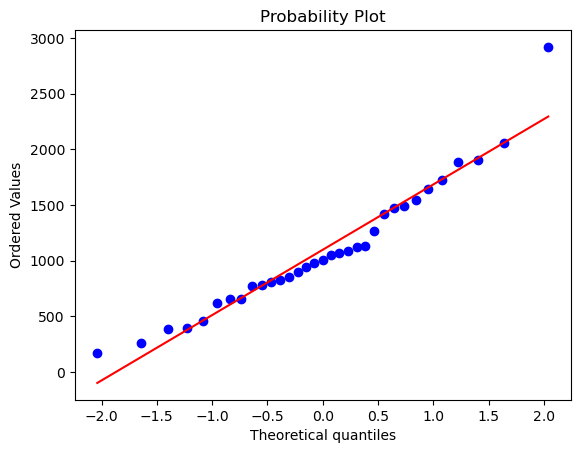

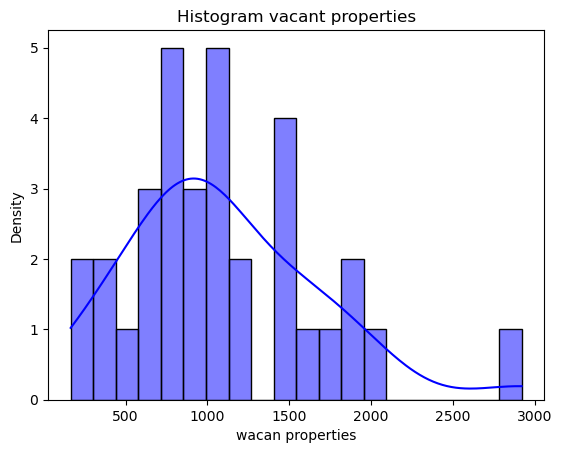

Shapiro-Wilk Test Statistic: 0.9488184332980764
P-value: 0.12287620212550787
Shapiro-Wilk Test Statistic: 0.948758632480925
P-value: 0.12238288672381503


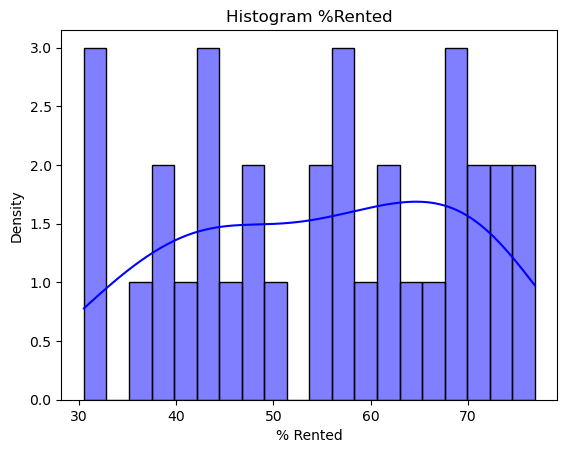

Skewness of Rented: -0.15706738004149598
Skewness of Owned: 0.15761744307702397


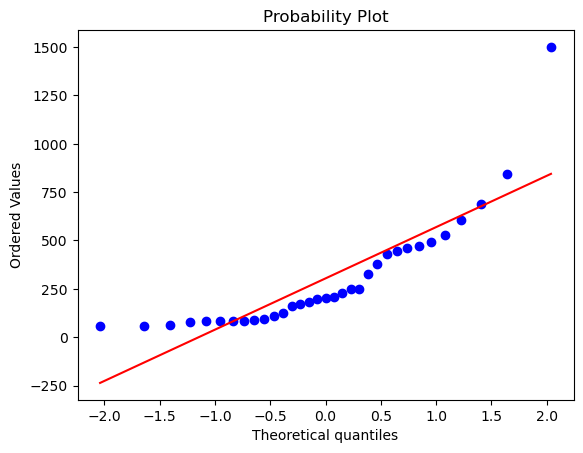

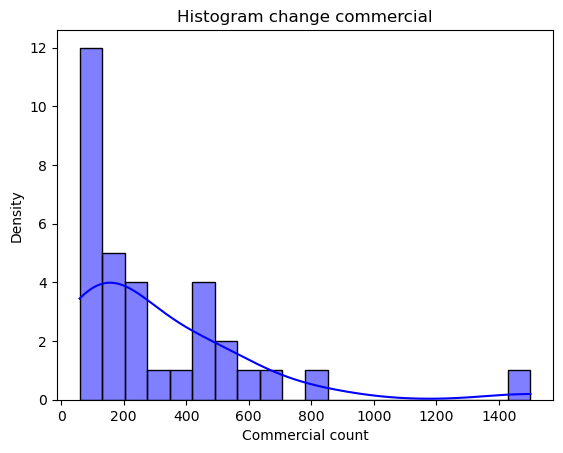

Shapiro-Wilk Test Statistic: 0.9570339752429177
P-value: 0.21278228787968184
Skewness of distance: 0.0657900440473204


'\nFrom all of these normality tests we have decided to transform the change in commercial listings count and the number of vacant \nproperties, not only are they counts but tests for normality, skewness and descriptive visuals show that they are not normally distributed \nwhich may violate the assumptions of a linear relationshio. Likewise by compressing large values it could make the spread of residuals\nmore consistant across the range of data. \nLimitations: overfitting? Potentially changing the interpretation , oh well that is what they did. \n'

In [69]:
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns


#shapiro wilk test to see if the data is normally distributed
#-------  on the listings data ---------

# Perform the Shapiro-Wilk test
stat, p_value = shapiro(merged_borough_counts["Commercial_change"])

# Display the results
print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p_value}")


#the W values 0.7... is less than 1 (suggesting that the data is not normally distributed) and the p value 0.00000505 is <0.05
#therefore the null hypothesis which assumes that the data is normally distributed is rejected 



# ----------- Perform the test on the '2023' column ------ #
stat, p_value = shapiro(df_vacantprops[2023])
print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p_value}")

#Interpretation 
#0.9465112270729066 W value close to one so its close to normal 
#p value is 0.10520533110791175 greater than 0.05 so we can fail to reject the null hypothesis as there is no significant evidence
#that the data is not normally distributes



# Create Q-Q plot
stats.probplot(df_vacantprops[2023], dist="norm", plot=plt)
plt.show()

#hist to actually visualise the distribution to determine whether we transform or not
# Histogram with a density line
sns.histplot(df_vacantprops[2023], kde=True, color="blue", bins=20)

# Adding labels and title
plt.xlabel('wacan properties')
plt.ylabel('Density')
plt.title('Histogram vacant properties')

# Show plot
plt.show()

#as you can see it is still a bit skewed to the right



#Now we'll do one for the proportion owned and rented 
stat, p_value = shapiro(df_censusTenure['Rented'])
print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p_value}")

#owned
stat, p_value = shapiro(df_censusTenure['Owned'])
print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p_value}")

#hist to actually visualise the distribution to determine whether we transform or not
# Histogram with a density line
sns.histplot(df_censusTenure['Rented'], kde=True, color="blue", bins=20)

# Adding labels and title
plt.xlabel('% Rented')
plt.ylabel('Density')
plt.title('Histogram %Rented')

# Show plot
plt.show()

#it looks asymetrical with a very slight skew so will use further tests to check 

# checking ifits skewed
from scipy.stats import skew

skew_rented = skew(df_censusTenure['Rented'])
skew_owned = skew(df_censusTenure['Owned'])

print(f"Skewness of Rented: {skew_rented}")
print(f"Skewness of Owned: {skew_owned}")

'''
The values are close to 0 althouhh the alues Skewness of Rented: -0.15706738004149598
Skewness of Owned: 0.15761744307702397 suggest a slight skew them being so close to 0 and looking at the hist plots 
and the fact that they are also percentages not counts means that transformation is not necessary
'''


# Create Q-Q plot
stats.probplot(merged_borough_counts['Commercial_change'], dist="norm", plot=plt)
plt.show()


# Histogram with a density line
sns.histplot(merged_borough_counts['Commercial_change'], kde=True, color="blue", bins=20)

# Adding labels and title
plt.xlabel('Commercial count')
plt.ylabel('Density')
plt.title('Histogram change commercial')

# Show plot
plt.show() 


# ------- Checking the normality for distance to centre 

stat, p_value = shapiro(boro['distance_to_midpoint'])
print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p_value}")

#Shapiro-Wilk Test Statistic: 0.9570339752429177 #the value is very close to normal 
#P-value: 0.21278228787968184 #fail to reject the null hypiothesis 

# skew test
skew_dist = skew(boro['distance_to_midpoint'])
print(f"Skewness of distance: {skew_dist}")

#very close to normal and not skewed in a meaningful way 
#Skewness of distance: 0.0657900440473204



'''
From all of these normality tests we have decided to transform the change in commercial listings count and the number of vacant 
properties, not only are they counts but tests for normality, skewness and descriptive visuals show that they are not normally distributed 
which may violate the assumptions of a linear relationshio. Likewise by compressing large values it could make the spread of residuals
more consistant across the range of data. 
Limitations: overfitting? Potentially changing the interpretation , oh well that is what they did. 
'''

**merging the datasets**

In [105]:
import pandas as pd


# Merge using different column names
vacantprops_with_tenure = pd.merge(df_vacantprops[['LAcode', 'LAname', 2023]],  # Fix here
                                   df_censusTenure[['mnemonic', 'Owned', 'Rented']], 
                                   left_on='LAcode',  # Column in df_vacantprops
                                   right_on='mnemonic',  # Column in df_censusTenure
                                   how='inner')

# Print the first few rows of the merged DataFrame
#print(vacantprops_with_tenure.head())



# Merging vacantprops_with_tenure with merged_borough_counts to add Commercial Change
vacantprops_with_tenure_and_commercial = pd.merge(
    vacantprops_with_tenure, 
    merged_borough_counts[['GSS_CODE', 'Commercial_change']], 
    left_on='LAcode',  # Merge on LAcode from vacantprops_with_tenure
    right_on='GSS_CODE',  # Merge on GSS_CODE from merged_borough_counts
    how='inner'  # Inner join to only keep matching rows
)

# Merging the result with boro to add Distance to Midpoint
final_merged_data = pd.merge(
    vacantprops_with_tenure_and_commercial, 
    boro[['GSS_CODE', 'distance_to_midpoint']], 
    on='GSS_CODE',  # Merge on GSS_CODE which is common
    how='inner'  # Inner join to keep only matching rows
)

# Display the final merged dataframe
#print(final_merged_data)

# Drop the redundant columns (keeping only one column: GSS_CODE)
merged_boroughs_unique = final_merged_data.drop(columns=['GSS_CODE', 'mnemonic'])

# Display the DataFrame after dropping redundant columns
#print(merged_boroughs_unique)

# Merge df_rental_comparison with final_merged_data using the 'LAcode' and 'mnemonic' as keys
final_data_with_rentals = pd.merge(
    final_merged_data,  # previously merged data
    df_rental_comparison[['Mnemonic', 'Price_Difference']],  # relevant columns from df_rental_comparison
    left_on='LAcode',  # Use 'LAcode' from final_merged_data
    right_on='Mnemonic',  # Use 'Mnemonic' from df_rental_comparison
    how='inner'  # Perform an inner join to keep only matching rows
)

# Drop the redundant 'Mnemonic' column after merging
final_data_cleaned = final_data_with_rentals.drop(columns=['GSS_CODE','Mnemonic', 'mnemonic'])

# Display the final merged DataFrame
print(final_data_cleaned)






       LAcode                  LAname    2023  Owned  Rented  \
0   E09000002    Barking and Dagenham   383.0   42.4    57.6   
1   E09000003                  Barnet  1905.0   52.7    47.4   
2   E09000004                  Bexley   655.0   68.6    31.4   
3   E09000005                   Brent  1053.0   38.4    61.6   
4   E09000006                 Bromley  1068.0   68.5    31.6   
5   E09000007                  Camden  1541.0   29.7    70.4   
6   E09000008                 Croydon  1639.0   54.7    45.3   
7   E09000009                  Ealing   460.0   46.2    53.8   
8   E09000010                 Enfield  1089.0   52.4    47.6   
9   E09000011               Greenwich  1123.0   41.1    58.9   
10  E09000012                 Hackney   977.0   24.6    75.4   
11  E09000013  Hammersmith and Fulham   778.0   32.1    67.9   
12  E09000014                Haringey  1468.0   37.2    62.7   
13  E09000015                  Harrow   827.0   58.8    41.2   
14  E09000016                Havering   

**Log transforming the data**

       LAcode                  LAname    2023  Owned  Rented  \
0   E09000002    Barking and Dagenham   383.0   42.4    57.6   
1   E09000003                  Barnet  1905.0   52.7    47.4   
2   E09000004                  Bexley   655.0   68.6    31.4   
3   E09000005                   Brent  1053.0   38.4    61.6   
4   E09000006                 Bromley  1068.0   68.5    31.6   
5   E09000007                  Camden  1541.0   29.7    70.4   
6   E09000008                 Croydon  1639.0   54.7    45.3   
7   E09000009                  Ealing   460.0   46.2    53.8   
8   E09000010                 Enfield  1089.0   52.4    47.6   
9   E09000011               Greenwich  1123.0   41.1    58.9   
10  E09000012                 Hackney   977.0   24.6    75.4   
11  E09000013  Hammersmith and Fulham   778.0   32.1    67.9   
12  E09000014                Haringey  1468.0   37.2    62.7   
13  E09000015                  Harrow   827.0   58.8    41.2   
14  E09000016                Havering   

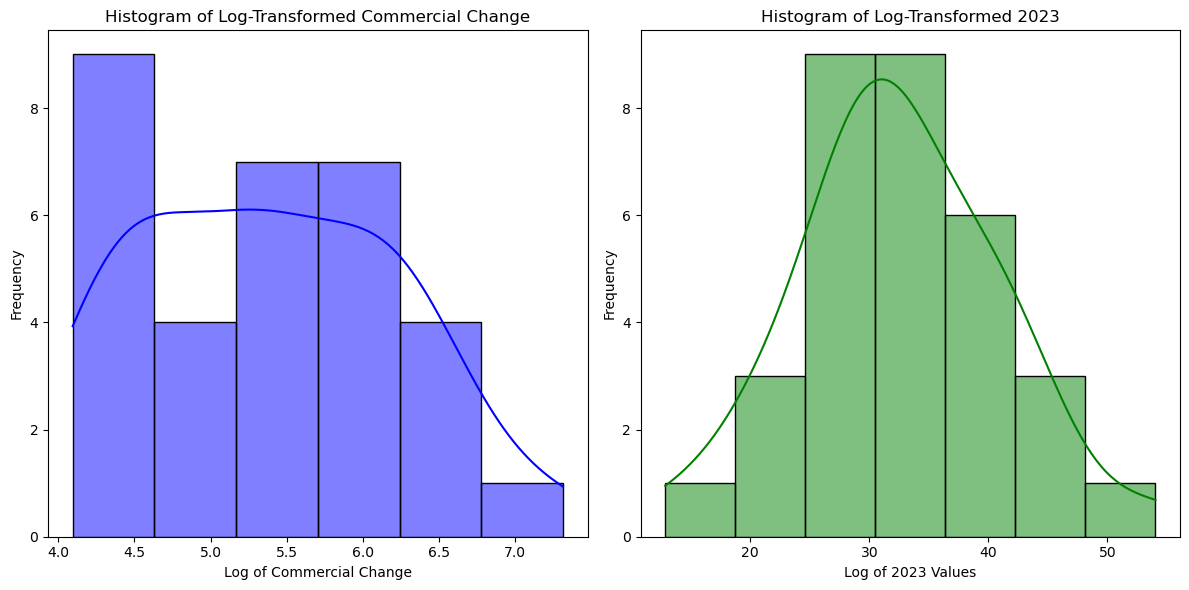

In [143]:
import numpy as np

# sqrt transform the 'Commercial_change' and '2023' columns heteroscedastic
final_data_cleaned['sqrt_Commercial_change'] = np.sqrt(final_data_cleaned['Commercial_change'])
final_data_cleaned['sqrt_2023'] = np.sqrt(final_data_cleaned[2023])

final_data_cleaned['sqrt_distance_to_midpoint'] = np.sqrt(final_data_cleaned['distance_to_midpoint'] + 1)  # Add 1 to avoid log(0)
final_data_cleaned['sqrt_pricedif'] = np.sqrt(final_data_cleaned['Price_Difference'] + 1)  # Add 1 to avoid log(0)


#because hetero

# Display the dataframe after log transformation
print(final_data_cleaned)

## --- doing the shapiro test again on both 
        ## logged commercial data ##
# Perform the Shapiro-Wilk test
stat, p_value = shapiro(final_data_cleaned["sqrt_Commercial_change"])
## Shapiro-Wilk Test Statistic: 0.9556339522701023
#P-value: 0.20788115435839877

# Display the results
print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p_value}")
##Shapiro-Wilk Test Statistic: 
       ## logged vacant homes/borough
# Perform the Shapiro-Wilk test
stat, p_value = shapiro(final_data_cleaned['sqrt_2023'])

# Display the results
print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p_value}")
## Shapiro-Wilk Test Statistic: 0.9525811247269396
# P-value: 0.17056281859711886

import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure for the histograms
plt.figure(figsize=(12, 6))

# Plot histogram for log-transformed Commercial Change
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.histplot(final_data_cleaned['log_Commercial_change'], kde=True, color='blue')
plt.title('Histogram of Log-Transformed Commercial Change')
plt.xlabel('Log of Commercial Change')
plt.ylabel('Frequency')

# Plot histogram for log-transformed 2023 values
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.histplot(final_data_cleaned['sqrt_2023'], kde=True, color='green')
plt.title('Histogram of Log-Transformed 2023')
plt.xlabel('Log of 2023 Values')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

## its good enough ## hopefully it wont skew the resid 


In [149]:
import pandas as pd
import statsmodels.api as sm

#### --------- Fitting the model --------- ###

# Defining the independent variables (X) and the dependent variable (y)
X = final_data_cleaned[['sqrt_Commercial_change', 'sqrt_2023','Rented']]  # Independent variables
y = final_data_cleaned['sqrt_pricedif']  # Dependent variable

# Adding a constant to the model (for the intercept)
X = sm.add_constant(X)

# Fitting the model using OLS (Ordinary Least Squares)
model = sm.OLS(y, X).fit()

# Display the summary of the regression
print(model.summary())




                            OLS Regression Results                            
Dep. Variable:          sqrt_pricedif   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     58.77
Date:                Sat, 07 Dec 2024   Prob (F-statistic):           3.33e-12
Time:                        05:23:38   Log-Likelihood:                -47.157
No. Observations:                  32   AIC:                             102.3
Df Residuals:                      28   BIC:                             108.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      4

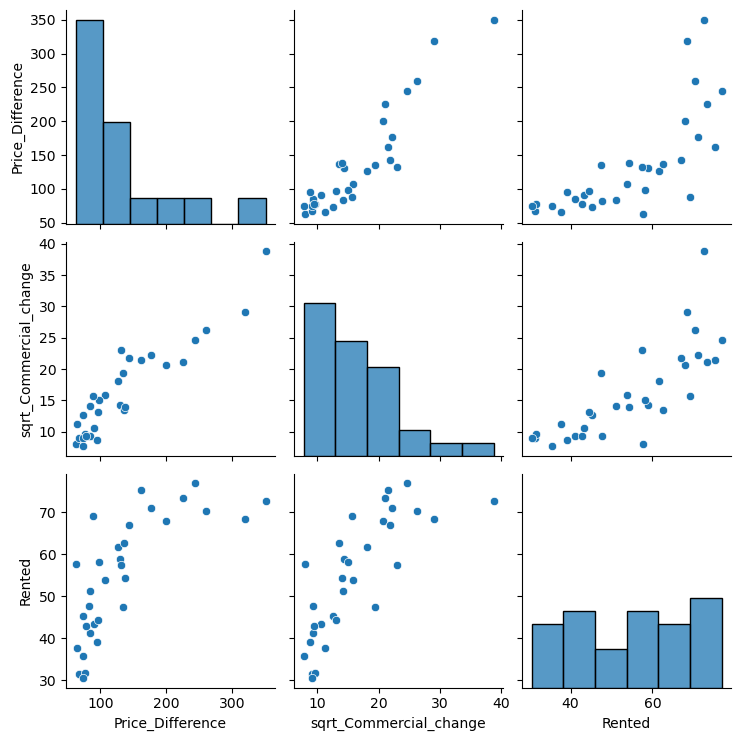

In [148]:
#trying to fitthe model assumtions
#checking if the relationshipis linear 
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for each independent variable vs Price_Difference
sns.pairplot(final_data_cleaned[['Price_Difference', 'sqrt_Commercial_change', 'Rented']])
plt.show()



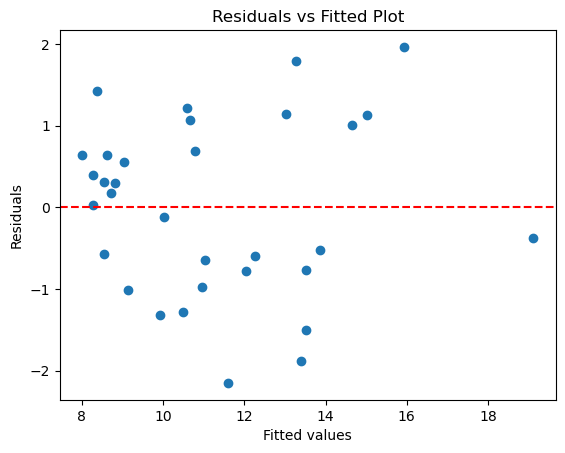

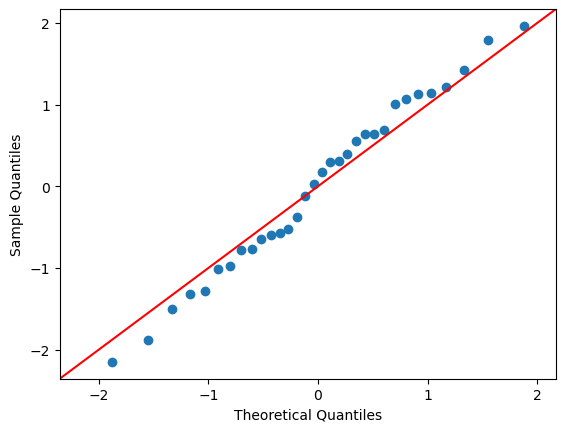

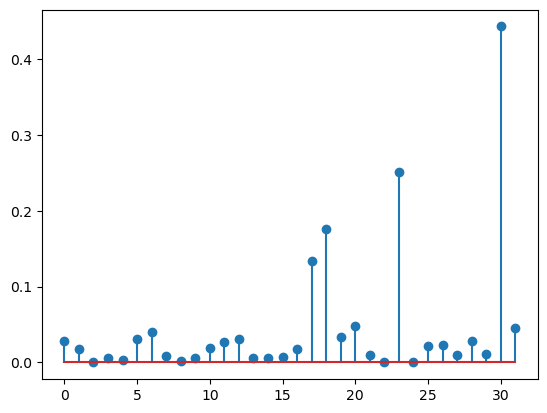

In [150]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Get residuals and fitted values
residuals = model.resid
fitted = model.fittedvalues

# Create a scatter plot
plt.scatter(fitted, residuals)
plt.axhline(y=0, color='red', linestyle='--')  # add a horizontal line at 0
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Plot')
plt.show()

sm.qqplot(residuals, line ='45')
plt.show()

influence = model.get_influence()
cooks_distance = influence.cooks_distance
plt.stem(cooks_distance[0])
plt.show()



In [146]:
# Using robust standard errors in OLS
robust_model = model.get_robustcov_results()
print(robust_model.summary())


                            OLS Regression Results                            
Dep. Variable:          sqrt_pricedif   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     51.09
Date:                Sat, 07 Dec 2024   Prob (F-statistic):           3.29e-12
Time:                        05:22:58   Log-Likelihood:                -47.156
No. Observations:                  32   AIC:                             104.3
Df Residuals:                      27   BIC:                             111.6
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [147]:
#checking the VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add constant to the independent variables for VIF calculation
X_with_const = add_constant(X)

# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# Display VIF values
print(vif_data)


                    Variable         VIF
0                      const  424.327780
1     sqrt_Commercial_change    4.580628
2                  sqrt_2023    1.166923
3  sqrt_distance_to_midpoint    7.739540
4                     Rented    4.325489


In [113]:
# Check correlation matrix
correlation_matrix = final_data_cleaned[['log_Commercial_change', 'distance_to_midpoint', 'log_2023']].corr()
print(correlation_matrix)


                       log_Commercial_change  distance_to_midpoint  log_2023
log_Commercial_change               1.000000             -0.879991  0.286928
distance_to_midpoint               -0.879991              1.000000 -0.320259
log_2023                            0.286928             -0.320259  1.000000


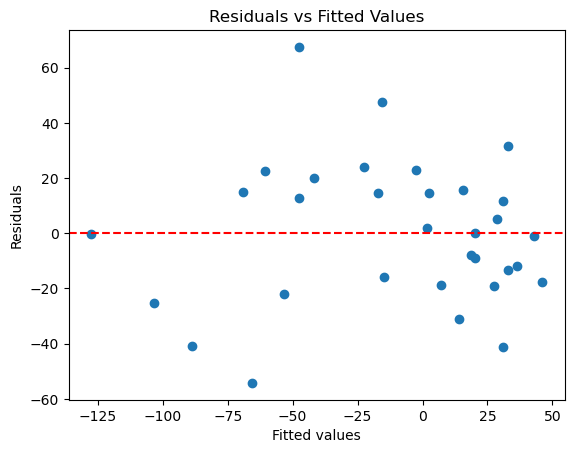

In [68]:
#checking the residuals 
residuals = model.resid
plt.scatter(model.fittedvalues, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()


In [69]:
# Fit the model with robust standard errors
model_robust = sm.OLS(y, X).fit(cov_type='HC3')  # HC3 is a robust option for heteroscedasticity

# Display model summary
print(model_robust.summary())


                            OLS Regression Results                            
Dep. Variable:       Price_Difference   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     59.47
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           5.47e-11
Time:                        19:31:46   Log-Likelihood:                -149.38
No. Observations:                  32   AIC:                             304.8
Df Residuals:                      29   BIC:                             309.2
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             67.6873     11.853      5.